# Data normalization

Data normalization means that we want to set the mean and std of each image channel to a set value. 
Usually, the mean is set to 0 and standard deviation to 1. 

1. This keeps the data in the range that the activation function is activated.
2. Also, it makes sure that the distribution in the 3 channels is similar. We want to have learning rate that is appropriate to the different channels.

Normalization should facilitate learning.

The strategy here is as follows:

1. Calculated the mean and standard deviation of the images channels in our dataset.
2. Apply this normalization to our transofrm pipeline when we get images from the dataset.
3. Apply this normalization when we get new images to process (assuming they are coming from the same distribution as those in the dataset).

In this notebook, we will calculate the mean and std of each channel and save the information in the project configuration file for later use.

In [1]:
# this will run the code in the setup_project.py and create a variable called `project`
%run setup_project.py

from torch import optim
import torch
import torch.nn as nn
import albumentations as A

from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet

Project directory: /home/kevin/Documents/trackingProjects/finger_tracker
Getting configuration from config file. Values from config file will be used.
Loading /home/kevin/Documents/trackingProjects/finger_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'finger_tracker', 'normalization_values': {'means': [0.4079657196998596, 0.4543980062007904, 0.5158050656318665], 'stds': [0.23991422355175018, 0.25161123275756836, 0.26905474066734314]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['f1', 'f2', 'f3', 'f4'], 'target_radius': 6, 'unet_features': [64, 128, 256, 512]}


In [2]:
dataset = UNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinate_dir=project.coordinate_dir, 
                      image_extension=project.image_extension)

In [3]:
len(dataset)

213

## Calculate means and standard deviation of each color channel

We have a function in the dataset class to do just this. It loads all images, calculates the mean and standard deviation per color channel, and returns them.

In [4]:
means,stds = dataset.get_normalization_values()

In [5]:
print("means:",means)
print("stds:", stds)

means: [104.06872 115.90846 131.5772 ]
stds: [61.15911  64.14642  68.610275]


## Saving normalization values in the project configuration

We can save the normalization values in the project object and to the configuration file.

I am dividing the values by the maximum value for a pixel (usually 255). 

The formula for normalization in the [Albumentations normalization](https://albumentations.ai/docs/api_reference/augmentations/transforms/) function is : `img = (img - mean * max_pixel_value) / (std * max_pixel_value)`

In [6]:
project.set_normalization_values(means/255.0,stds/255.0)
project.normalization_values

{'means': [0.40811261534690857, 0.45454299449920654, 0.5159890055656433],
 'stds': [0.23983965814113617, 0.25155460834503174, 0.2690598964691162]}

In [7]:
project.save_configuration()

Saving /home/kevin/Documents/trackingProjects/finger_tracker/config.yalm


In [8]:
project.load_configuration()

Loading /home/kevin/Documents/trackingProjects/finger_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'finger_tracker', 'normalization_values': {'means': [0.40811261534690857, 0.45454299449920654, 0.5159890055656433], 'stds': [0.23983965814113617, 0.25155460834503174, 0.2690598964691162]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['f1', 'f2', 'f3', 'f4'], 'target_radius': 6, 'unet_features': [64, 128, 256, 512]}


## Apply normalization when training the network

You can apply normalization by setting the transform argument of the dataset. 

Here is an example. 

In [9]:
means = project.normalization_values["means"]
stds = project.normalization_values["stds"]

transform = A.Compose([A.Normalize(mean=means, std=stds)])
transform

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.40811261534690857, 0.45454299449920654, 0.5159890055656433], std=[0.23983965814113617, 0.25155460834503174, 0.2690598964691162], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

Here is one dataset without normalization and one with normalization.

In [10]:
datasetNoNorm = UNetDataset(image_dir=project.image_dir, 
                            mask_dir=project.mask_dir, 
                            coordinate_dir=project.coordinate_dir,
                            image_extension=project.image_extension)
datasetWithNorm = UNetDataset(image_dir=project.image_dir, 
                              mask_dir=project.mask_dir, 
                              coordinate_dir=project.coordinate_dir,
                              transform=transform, # we pass our transform function to the UNetDataset object
                              image_extension=project.image_extension)

In [11]:
imgNoNorm,_,_ = datasetNoNorm[0]
imgWithNorm,_,_ = datasetWithNorm[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


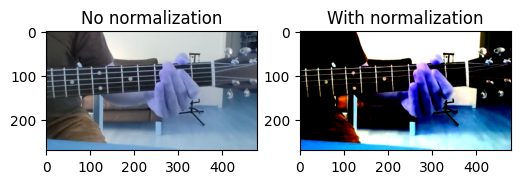

In [12]:
fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(imgNoNorm.permute(1,2,0)/255)
ax[0].set_title("No normalization")
ax[1].imshow(imgWithNorm.permute(1,2,0))
ax[1].set_title("With normalization")
plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(6,3),layout="constrained")
ax[0].hist(imgNoNorm.flatten(),bins=50)
ax[0].set_xlabel("Pixel values")
ax[0].set_title("No normalization")
ax[1].hist(imgWithNorm.flatten(),bins=50)
ax[1].set_xlabel("Pixel values")
ax[1].set_title("With normalization")
plt.show()